<a href="https://colab.research.google.com/github/DataScienceAndEngineering/deep-learning-final-project-project-sidewalk/blob/rabiul/notebooks/Rabiul/Cityscapes_data_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Lib

In [ ]:
#
%%time
import numpy as np
import pandas as pd
import os
import PIL
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm
from PIL import Image

from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive

import cv2
import glob
import pickle

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, BatchNormalization, ReLU, LeakyReLU, concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Add

CPU times: user 7.87 s, sys: 1.07 s, total: 8.94 s
Wall time: 17.7 s


# Initial Data processing

In [ ]:
%%time
!gdown --id 1mIDcIT_7vP9cQDl_D8zgX9g4Pe18-g5q -O leftImg8bit_trainvaltest.zip
!gdown --id 1ExL_qMIykksn_kpxZxi5DvltBgX-gHVn -O gtFine_trainvaltest.zip

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mIDcIT_7vP9cQDl_D8zgX9g4Pe18-g5q
To: /content/leftImg8bit_trainvaltest.zip
100% 11.6G/11.6G [01:45<00:00, 110MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ExL_qMIykksn_kpxZxi5DvltBgX-gHVn
To: /content/gtFine_trainvaltest.zip
100% 253M/253M [00:03<00:00, 77.6MB/s]
CPU times: user 1.47 s, sys: 311 ms, total: 1.78 s
Wall time: 1min 51s


In [ ]:
%%time
!unzip /content/drive/MyDrive/DL_Project/Data/gtFine_trainvaltest.zip
!unzip /content/drive/MyDrive/DL_Project/Data/leftImg8bit_trainvaltest.zip

In [ ]:
%%time
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cpu


In [ ]:
%%time
COLAB_DIR = '/content/'
GT_DIR = COLAB_DIR + 'gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg8bit/'

In [ ]:
%%time
# collapse child directories
for parent in listdir(GT_DIR):
    parent_dir = GT_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            keep = glob.glob(join(parent_dir, child) + '/*_gtFine_color.png')
            keep = [f.split('/')[-1] for f in keep]
            for filename in list(set(listdir(join(parent_dir, child))) & set(keep)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

for parent in listdir(IMG_DIR):
    parent_dir = IMG_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            for filename in listdir(join(parent_dir, child)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

In [ ]:
%%time
# process anr archive image in smaller size
IMG_SHAPE = 299, 299

gt_train_paths = [GT_DIR+'train/' + path for path in listdir(GT_DIR+'train/')]
gt_test_paths = [GT_DIR+'test/' + path for path in listdir(GT_DIR+'test/')]
gt_val_paths = [GT_DIR+'val/' + path for path in listdir(GT_DIR+'val/')]
gt_paths = gt_train_paths + gt_test_paths + gt_val_paths

im_train_paths = [IMG_DIR+'train/' + path for path in listdir(IMG_DIR+'train/')]
im_test_paths = [IMG_DIR+'test/' + path for path in listdir(IMG_DIR+'test/')]
im_val_paths = [IMG_DIR+'val/' + path for path in listdir(IMG_DIR+'val/')]
im_paths = im_train_paths + im_test_paths + im_val_paths

def resize_image(path):
    img = Image.open(path)
    img.thumbnail(IMG_SHAPE)
    out_file = join(path)
    img.save(out_file, 'PNG')

for img in gt_paths + im_paths:
    resize_image(img)
#saving the data for future use, avoding pre_processing task over and over 
make_archive('gtFine', 'zip', GT_DIR) 
make_archive('leftImg', 'zip', IMG_DIR)

#Load Pre_processed Data

In [29]:
%%time
#PreProcessed data is located in my personal Google Drive, its publically available. anyone can download it. 
!gdown --id 1kkmpZOGdncxjI6NEvFmZh85Wn2nrW3rK -O gtFine.zip
!gdown --id 14MXcx8G3yRLljLb1K0PYX7yCl5viPP-8 -O leftImg.zip


/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kkmpZOGdncxjI6NEvFmZh85Wn2nrW3rK
To: /content/gtFine.zip
100% 66.3M/66.3M [00:00<00:00, 157MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14MXcx8G3yRLljLb1K0PYX7yCl5viPP-8
To: /content/leftImg.zip
100% 339M/339M [00:02<00:00, 127MB/s]
CPU times: user 78.3 ms, sys: 46.2 ms, total: 125 ms
Wall time: 5.22 s


In [ ]:
%%time
!unzip /content/gtFine.zip -d '/content/gtFine/'
!unzip /content/leftImg.zip -d '/content/leftImg/'

In [42]:
# normalize image pixels
IMG_SIZE = 299
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

GT_DIR = COLAB_DIR + 'gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/'

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img /= 255.0
    return img

def get_image_paths(dir):
    return sorted([dir + path for path in listdir(dir)])

# create tf.Dataset objects
gt_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'train/'))
gt_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'val/'))
gt_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'test/'))

gt_train_ds = gt_train_ds.map(load_and_preprocess_image)
gt_val_ds = gt_val_ds.map(load_and_preprocess_image)
gt_test_ds = gt_test_ds.map(load_and_preprocess_image)

im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'train/'))
im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'val/'))
im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'test/'))

im_train_ds = im_train_ds.map(load_and_preprocess_image)
im_val_ds = im_val_ds.map(load_and_preprocess_image)
im_test_ds = im_test_ds.map(load_and_preprocess_image)

2975

# Visualize Data

In [47]:
def visualize_images(img, gt, pred):
    if pred is not None:
        fig, axes = plt.subplots(1, 3, figsize=(12, 8))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(8, 8))

    axes[0].imshow(img)
    axes[0].set_title('Actual Image')

    axes[1].imshow(gt)
    axes[1].set_title('Masked Image')
    
    if pred is not None:
        axes[2].imshow(pred)
        axes[2].set_title('Predicted Image')

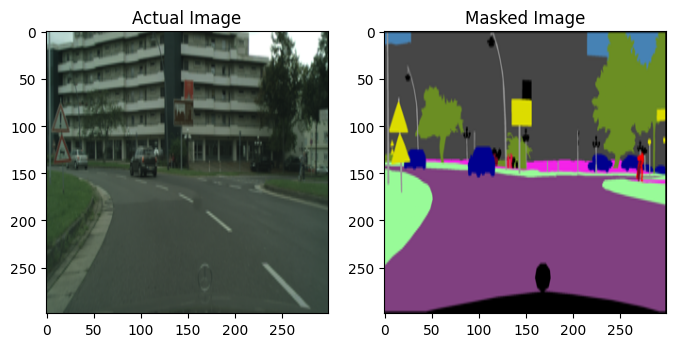

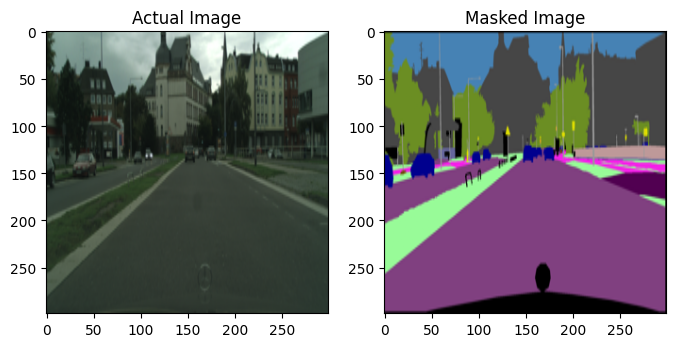

In [48]:
for img, gt in list(zip(im_train_ds.take(2), gt_train_ds.take(2))):
    visualize_images(img, gt, None)